# Neural Network Modeling Notebook

### Imports:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time


import re

from sklearn.preprocessing import StandardScaler

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras.utils import np_utils
from keras import optimizers

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, roc_curve, auc

%matplotlib inline

Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
from numpy.random import seed
from tensorflow import set_random_seed

# Set random seed to ensure reproducible results
rand_seed = 112
seed(rand_seed)
set_random_seed(rand_seed)

### Load the Data:

In [3]:
# has_planets = pd.read_csv('../clean_planet_data/clean_labeled_planets_seed.csv')

In [4]:
# c4_kep = pd.read_csv('../clean_planet_data/clean_labeled_c4_kep_seed.csv')

In [5]:
has_planets = pd.read_csv('https://hkvbeg.bn.files.1drv.com/y4mb-PSrD6ZisUltffu15Ka3BXb_DrfmCPvaKYTWhbahR2pnLr1x6VpRjSWeKzor3RD_qlL7tuaSg_Hb07umXqRc6uqMWwrwW0tBAEhIasLErimEru4S8H-cvw2fhOfIG0_RVyeGKsO859mj3y7EwFFw0B3qXy7szqPs92nvZ1fJ2K1MFegUtjfDN_og-T1DpLN/clean_labeled_planets_seed.csv?download&psid=1')

In [6]:
c4_kep = pd.read_csv('https://hkveeg.bn.files.1drv.com/y4m7mHQxUOaHeIegxylT-Kq6i8hoEDZ_0XRCGTFBmi5Ba1QMm3ZRmRKWf9GJphOQFVWR8dSrqqiuYzEWOTKt5Etvku-hVFf_5Ns92TGL72X4KaOI2Z6awQ253woinxn3ER-EL_8hbp2hyCozbu0sWdAiLKWRZbjZcLwoExg5K5CyS1-gIsSsIP3xjCZxJ-69KN4/clean_labeled_c4_kep_seed.csv?download&psid=1')

<hr>

# Preprocessing Data:
### Mix confirmed planets into data so the model can learn what they are like.

In [7]:
c4_kep['label'].value_counts()

0    7648
1      65
Name: label, dtype: int64

In [8]:
# cut out the extra data to compare across the same timeline (~3200 points)
join_planets = has_planets.iloc[:,:3199]

# split c4_kep to add to training data
to_train_on = c4_kep.head(2705).iloc[:,:3199]
# to_train_on.columns = join_planets.columns

# set aside the last 5000 stars as a holdout set
c4_holdout = c4_kep.tail(5000).iloc[:,:3199]
# c4_holdout.columns = join_planets.columns

In [9]:
master_df = pd.concat([join_planets, to_train_on], axis = 0)

In [10]:
# Calculate Baseline Accuracy
val_count = master_df['label'].value_counts()
base_acc = val_count[1] / val_count.sum()

print('Baseline Acc: ', base_acc)
print(val_count)

Baseline Acc:  0.3056203056203056
0    2681
1    1180
Name: label, dtype: int64


### Scaling
Normalize the light curves so that stars of different brightnesses can be compared.

In [11]:
# Make X and y
X = master_df.iloc[:, 2:]
y = master_df['label']

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

In [12]:
# instantiate StandardScaler as ss
ss = StandardScaler()

In [13]:
# transpose to scale each lightcurve row (rather than columns)
X_train = X_train.T
X_test = X_test.T

# Scaling
scaled_df = ss.fit_transform(X_train)
X_train = pd.DataFrame(scaled_df, columns=X_train.columns)

test_scaled_df = ss.fit_transform(X_test)
X_test = pd.DataFrame(test_scaled_df, columns=X_test.columns)

# Transpose back to normal
X_train = X_train.T
X_test = X_test.T

In [14]:
# make into an array and then change the dimensions
X_array = np.array(X_train)
X_array = np.expand_dims(X_array, axis = 2)

# do this for the test set too
X_test_array = np.array(X_test)
X_test_array = np.expand_dims(X_test_array, axis = 2)

### Prepare Unseen Dataset:

In [15]:
# slice out the light curve
unseen_data = c4_holdout.iloc[:,2:3199]

# Scale
unseen_data = unseen_data.T # transpose to scale each lightcurve row (rather than columns)

scaled_unseen = ss.fit_transform(unseen_data)
unseen_data = pd.DataFrame(scaled_unseen, columns=unseen_data.columns)

unseen_data = unseen_data.T # Transpose back to normal

# Change the dimensions so it can be put through the neural network
array_unseen = np.array(unseen_data)
array_unseen = np.expand_dims(array_unseen, axis = 2)

<hr>

# Define Functions for Evaluating the Results Later:

In [16]:
# This will be used later to show how the model learned over the epochs

def learning_plots(title, metric, val_metric, y_label, c_train='#1f77b4', c_test='orange'):

    # Instantiate plot
    plt.figure()

    # Plot metric of interest
    plt.plot(result.history[metric], color = c_train)
    plt.plot(result.history[val_metric], color = c_test)

    # Set title
    plt.title(title)

    # Set axis labels
    plt.ylabel(y_label)
    plt.xlabel('Epoch (# of iterations)')

    # Add a legend
    plt.legend(['Train', 'Test'], loc='best')

    # Plot girdlines:
    plt.grid()

    plt.show();

This will be used for showing the evaluation metrics.

In [17]:
def analyze_results(predictions, y_test): #, all_results):


    # Calculate 
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    total = (tp + tn + fp + fn)

    
    index_labels = ['Accuracy', 'Sensitivity', 'Specificity', 'Precision']
    scores = pd.DataFrame(index = index_labels, columns=['Results'])
    
# Calculate results
    decimals = 3

    scores.loc['Accuracy'] = round((tp+tn) / (total), decimals)
    scores.loc['Sensitivity'] = round(tp / (tp+fn), decimals)
    scores.loc['Specificity'] = round(tn / (tn+fp), decimals)
    scores.loc['Precision'] = round(tp / (tp+fp), decimals)

    # Display the rounded results
    display(scores)
    
# Calculate values for the confusion matrix

    confusion = pd.DataFrame(index= ['Pred. Positive','Pred. Negative', 'Total'])

    confusion['Act. Positive'] = tp, fn, (tp + fn)
    confusion['Act. Negative'] = fp, tn, (fp + tn)

    confusion['Total'] = (tp + fp), (fn + tn), total

    display(confusion)
    
    print((tp + fp), 'predicted to have planets', '\n',
    tp, 'true positive planet stars predicted', '\n',
    round(tp/(tp+fn)*100, 3), '% of all true planets', '\n') 
    
    # Rate of planets in predictions
    tp_rate = (tp / (tp + fp))
    # Rate of planets in all unseen test set
    all_rate = (tp + fn) / total
    
    print(round(tp_rate / all_rate, 3), 'times better than chance')
    
    # False positive rate
    print(round(fp/(tp+fp)*100, 3), '% false positive rate')
    
    return scores, confusion

This will be used to plot the auc-roc curve when evaluating the predictions.

In [59]:
def plot_roc(y_test, y_hat_proba):
# Plot ROC-AUC curve

    # Generate False positive rate and True positive rate
    fpr, tpr, _ = roc_curve(y_test, y_hat_proba)
    roc_auc = auc(fpr, tpr)

# Plot settings
    plt.figure(figsize=(6, 4))
    line_width = 4
    
    # Title and labels
    plt.title('ROC Curve', fontsize=25, position = (0.2,1))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    
    # Gridlines
    plt.grid(True)
    
    plt.plot(fpr, tpr, lw = line_width)
    plt.plot([0, 1], [0,1], lw = line_width, linestyle = '--')

<hr>

# Neural Network Modeling:
### Architecture:

In [64]:
# Define model architecture
model = Sequential()

# Convolutional and layer.
model.add(Conv1D(filters = 15, # tuned for 15
                 kernel_size = (20),  # filter size, tuned for 20
                 activation = 'relu',
                 input_shape = (3197, 1))) # dimensions of training data

# model.add(MaxPooling1D(pool_size = (1)))

# Convolutional layer
model.add(Conv1D(filters = 20, 
                 kernel_size = 30, # best so far 30
                 activation = 'relu'))

# model.add(MaxPooling1D(pool_size = (1)))

# Convolutional layer
model.add(Conv1D(filters = 10, # best so far 10
                 kernel_size = 60, # best so far 60
                 activation = 'relu'))

# Convolutional layer
model.add(Conv1D(filters = 20, 
                 kernel_size = 20,
                 activation = 'relu'))






# Pooling:
model.add(MaxPooling1D(pool_size = (3))) # best so far 3
model.add(Dropout(0.3)) # best so far .2




# Convolutional layer
model.add(Conv1D(filters = 20, 
                 kernel_size = 30,
                 activation = 'relu'))




# Convolutional layer
model.add(Conv1D(filters = 7, # tuned for 7, new-
                 kernel_size = 20, # tuned for 20, new-
                 activation = 'relu'))

# model.add(Conv1D(filters = 7,
#                  kernel_size = 10, # 5?
#                  activation = 'relu'))

# Pooling layer.
model.add(MaxPooling1D(pool_size = (5))) # best so far 5
model.add(Dropout(0.4)) # regularization tuned for .25, confirmed 2nd round







# Convolutional layer
model.add(Conv1D(filters = 10, # tuned to 10, confirmed 2nd round
                 kernel_size = 30, # tuned to 10, second round ~30
                 activation = 'relu'))

# model.add(Conv1D(filters = 7,
#                  kernel_size = 5, # 5?
#                  activation = 'relu'))

# Pooling layer.
model.add(MaxPooling1D(pool_size = (5))) # tuned to 5, confirmed 2nd round
model.add(Dropout(0.5)) # regularization tuned to .5



# Organize neurons by flattening.
model.add(Flatten())

# Fully connected hidden layers.

# Hidden layer 1
model.add(Dense(2500, activation = 'relu')) # 1st round- 2500, .7 drop
model.add(Dropout(0.5)) # best so far .4

model.add(Dense(1500, activation = 'relu')), # 1st round- 1000, .7 drop, 2nd best so far 1500, .4 drop
model.add(Dropout(0.5)) # best so far .5?

# model.add(Dense(500, activation = 'relu'))



# Output layer
model.add(Dense(1, activation = 'sigmoid'))

# Setting learning rate and decay
learn_rate = 0.001
# # x% reduction in learing_rate by epoch: coef_by_epoch
# coef_reduce = .75
# coef_by_epoch = 30

# Calculate decay
decay = 0 #(learn_rate - (coef_reduce * learn_rate)) / coef_by_epoch

# Changing adam optimization parameters
optimizers.adam(lr = learn_rate, decay = decay)

# Compile model
model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

### Fit the Network:

In [65]:
# Keep track of the runtime:
start_time = time.time()

# Set the random state
rand_seed = 112
seed(rand_seed)
set_random_seed(rand_seed)

# Fit the model:
result = model.fit(X_array,
                    y_train,
                    batch_size = 64,
                    epochs = 35,
                    verbose = 1,
                   validation_data = (X_test_array, y_test))

# Print the runtime:
print('Runtime: ', round((time.time() - start_time)/60, 3), ' minutes')

Train on 2895 samples, validate on 966 samples
Epoch 1/35
2895/2895 [==============================] - 176s 61ms/step - loss: 0.6311 - acc: 0.6922 - val_loss: 0.6202 - val_acc: 0.6946
Epoch 2/35
2895/2895 [==============================] - 138s 48ms/step - loss: 0.5947 - acc: 0.6943 - val_loss: 0.5911 - val_acc: 0.6946
Epoch 3/35
2895/2895 [==============================] - 138s 48ms/step - loss: 0.5861 - acc: 0.6943 - val_loss: 0.6335 - val_acc: 0.6946
Epoch 4/35
2895/2895 [==============================] - 138s 48ms/step - loss: 0.5817 - acc: 0.6940 - val_loss: 0.6535 - val_acc: 0.7008
Epoch 5/35
2895/2895 [==============================] - 139s 48ms/step - loss: 0.5752 - acc: 0.7040 - val_loss: 0.5759 - val_acc: 0.7060
Epoch 6/35
2895/2895 [==============================] - 138s 48ms/step - loss: 0.5684 - acc: 0.7136 - val_loss: 0.5970 - val_acc: 0.7246
Epoch 7/35
2895/2895 [==============================] - 139s 48ms/step - loss: 0.5589 - acc: 0.7188 - val_loss: 0.5537 - val_acc: 0

### Network Training Plots:
Training accuracy and loss functions vs. epochs

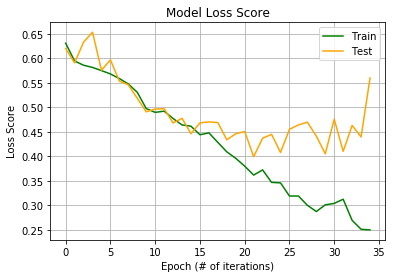

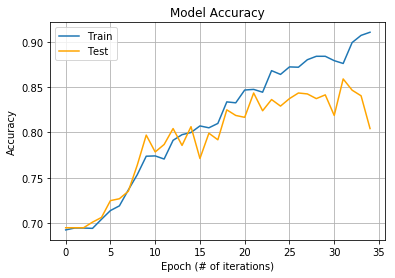

In [66]:
# Plot loss score over epoch
learning_plots(title = 'Model Loss Score', 
               metric = 'loss', 
               val_metric = 'val_loss', 
               y_label = 'Loss Score',
              c_train = 'green',
              c_test = 'orange')

# Plot accuracy over epochs
learning_plots(title = 'Model Accuracy', 
               metric = 'acc', 
               val_metric = 'val_acc', 
               y_label = 'Accuracy')

### Testing on Unseen Data:
Now that the model has been fit, lets see if we can use it to detect some planets in data not seen before.

In [67]:
# Make Predictions
y_unseen = model.predict_classes(array_unseen)
# Predict probabilities
pred_proba = model.predict_proba(array_unseen)

# make df of true labels and index
true_y_unseen = c4_holdout['label']

In [68]:
# Run the analyze_results function
results_df, confusion_df = analyze_results(predictions = y_unseen, 
                                           y_test = true_y_unseen)

,Results
Accuracy,0.925
Sensitivity,0.268
Specificity,0.931
Precision,0.031


,Act. Positive,Act. Negative,Total
Pred. Positive,11,343,354
Pred. Negative,30,4616,4646
Total,41,4959,5000


354 predicted to have planets 
 11 true positive planet stars predicted 
 26.829 % of all true planets 

3.789 times better than chance
96.893 % false positive rate


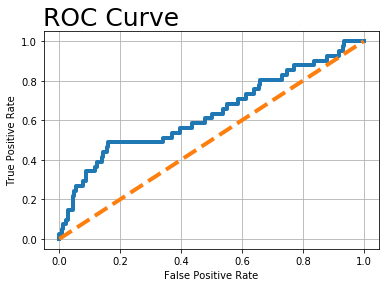

In [69]:
# Plot auc-roc curve
plot_roc(true_y_unseen, pred_proba)

### Done!

<hr>